In [1]:
import pickle, json
import seaborn as sns
import matplotlib.pyplot as plt
import re, os
from collections import defaultdict
from tqdm import tqdm

In [44]:
output_dir = "/home/myang4/mrt-analysis/outputs/r1/pass_at_k"
max_steps = 49 # maximum number of steps to break into
group_size = 5

### Merge data

In [ ]:
data = {}
for start in range(0, 40, 10):
    with open(os.path.join(output_dir, f'pass_at_k_{start}_{start+10}.pkl'), 'rb') as f:
        data |= pickle.load(f)


with open(os.path.join(output_dir, "pass_at_k.pkl"), "wb") as f:
    pickle.dump(data, f)

### Load data

In [46]:
with open(os.path.join(output_dir, "pass_at_k.pkl"), "rb") as f:
    data = pickle.load(f)

### Break into meta steps

In [47]:
def break_into_meta_steps(data):
    k_meta_steps = defaultdict(list)

    for n in tqdm(range(len(data))):
        for text in data[n]:
            meta_steps = []
            
            steps = text.split('\n\n')
            prev_i = 0
            num_s_steps = max_steps
            for i, step in enumerate(steps):
                if num_s_steps == 0:
                    break

                if step.startswith("Wait") or step.startswith("But wait") or step.startswith("Alternatively") or step.startswith("Is there another way to think about this?") or step.startswith("But let me double-check") or step.startswith("But hold on"):
                    
                    if prev_i == i or prev_i == i-1 or prev_i == i-2:
                        continue
                    
                    elif prev_i < i:
                        meta_step = "\n\n".join(steps[prev_i:i]).rstrip('\n')
                        meta_steps.append(meta_step)
                        num_s_steps -= 1
                    
                    prev_i = i

            if prev_i < len(steps):
                meta_step = "\n\n".join(steps[prev_i:]).rstrip('\n')
                meta_steps.append(meta_step)
            
            k_meta_steps[n].append(meta_steps)
    
    return k_meta_steps

In [48]:
k_meta_steps = break_into_meta_steps(data)

100%|██████████| 40/40 [00:00<00:00, 2084.44it/s]

### Plot step length distributions

In [49]:
def plot_step_lengths(k_meta_steps, binwidth=5):
    steps_dist = []

    for n, k_tries in k_meta_steps.items():
        for entry in k_tries:
            steps_dist.append(len(entry))

    sns.histplot(steps_dist, binwidth=binwidth, stat='count')
    plt.show()

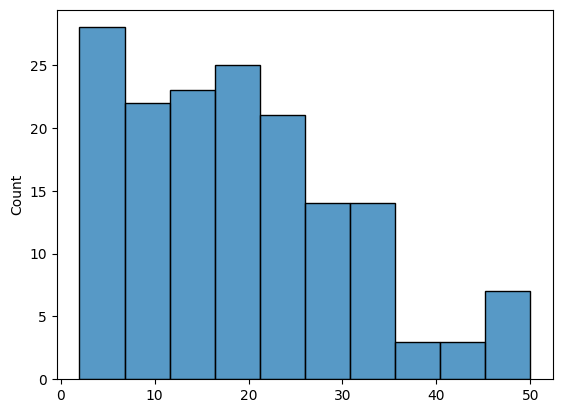

In [50]:
plot_step_lengths(k_meta_steps)

### Merge into larger meta steps

In [51]:
def merge_meta_steps(k_meta_steps):
    meta_steps = defaultdict(list)

    for n in k_meta_steps:
        for k in range(len(k_meta_steps[n])):
            new_k_meta_steps = []
            for i in range(0, len(k_meta_steps[n][k]), group_size):
                concatenated_meta_step = "\n\n".join(k_meta_steps[n][k][i:i+group_size])
                new_k_meta_steps.append(concatenated_meta_step)
            meta_steps[n].append(new_k_meta_steps)
    
    return meta_steps

In [52]:
meta_steps = {}
meta_steps = merge_meta_steps(k_meta_steps)

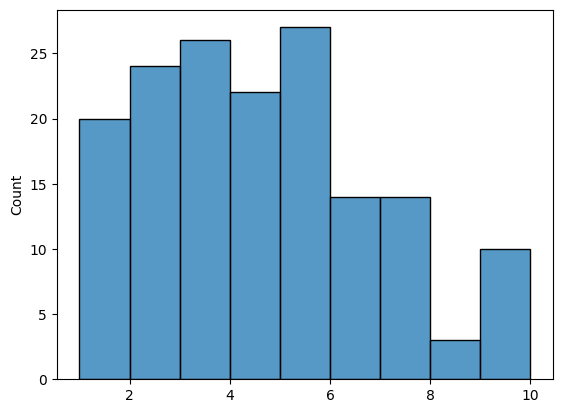

In [53]:
plot_step_lengths(meta_steps, binwidth=1)

### Save data

In [55]:
with open(os.path.join(output_dir, "prefixes.pkl"), "wb") as f:
    pickle.dump(meta_steps, f)